In [1]:
import sys
sys.path.append("../../")

from shared.sae_actions import load_pretrained_sae, sae_featurize_data 
from shared.models import MiniPileDataset
from shared.features import Feature, FeatureSample

%load_ext autoreload
%autoreload 2

/home/ubuntu/joe/predictive-saes/encoder_sae/venv/lib/python3.10/site-packages/pydantic/_internal/_config.py:341: UserWarning: Valid config keys have changed in V2:
* 'allow_mutation' has been removed
  warnings.warn(message, UserWarning)


In [2]:
# Load SAE
sae = load_pretrained_sae("../training_sae/saes/spam_messages_roberta_tied_weights_20241206_111202")

featurize train

In [3]:
import glob
import json
import os

def load_features(feature_dir):
    """Load features from JSON files and convert to Feature objects"""
    # Get all JSON files from the features directory
    feature_files = glob.glob(os.path.join(feature_dir, "*.json"))

    # Load all feature JSONs into Feature objects
    features = []
    for file in feature_files:
        with open(file) as f:
            feature_dict = json.load(f)
            
            # Convert samples to FeatureSample objects
            high_act_samples = [
                FeatureSample(text=s["text"], act=s["act"]) 
                for s in feature_dict["high_act_samples"]
            ]
            low_act_samples = [
                FeatureSample(text=s["text"], act=s["act"])
                for s in feature_dict["low_act_samples"] 
            ]
            
            feature = Feature(
                index=feature_dict["index"],
                label=feature_dict["label"],
                attributes=feature_dict["attributes"],
                reasoning=feature_dict["reasoning"],
                density=feature_dict["density"],
                confidence=feature_dict["confidence"],
                high_act_samples=high_act_samples,
                low_act_samples=low_act_samples
            )
            features.append(feature)

    # Sort features by index to maintain order
    features.sort(key=lambda x: x.index)

    # Extract labels and ids for easy reference
    autointerp_feature_labels = [f.label for f in features]
    autointerp_feature_ids = [f.index for f in features]

    return features, autointerp_feature_labels, autointerp_feature_ids

# Load features
feature_dir = "../feature_extraction/features/spam_messages_roberta_tied_weights"
features, autointerp_feature_labels, autointerp_feature_ids = load_features(feature_dir)


In [4]:
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

def prepare_dataset(sentences_file, embeddings_file, sae, autointerp_feature_ids=None, feature_registry_file="feature_registry.npy", label_column='label', text_key="text", split_sentences=True):
    # Load dataset
    df = pd.read_csv(sentences_file)
    
    # Create MiniPileDataset
    mini_pile_dataset = MiniPileDataset(sentences_file, embeddings_file, key=text_key)
    
    # Featurize data
    try:
        X = np.memmap(
            feature_registry_file,
            dtype="float32",
            mode="r",
            shape=(sae.encoder.weight.shape[0], len(mini_pile_dataset.sentences)),
        )
    except FileNotFoundError:
        X = sae_featurize_data(mini_pile_dataset, sae, output_file=feature_registry_file)
    
    X = X.T
    
    # Apply num_features if specified
    if autointerp_feature_ids is not None:
        X = X[:, autointerp_feature_ids]
    
    y = np.where(df[label_column] == 'ham', 0, 1)
    
    if split_sentences:
        X_split = []
        y_split = []
        for i, text in enumerate(df[text_key]):
            sentences = sent_tokenize(text)
            X_split.extend([X[i]] * len(sentences))
            y_split.extend([y[i]] * len(sentences))
        X = np.array(X_split)
        y = np.array(y_split)
    
    return X, y

[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
sentences_file = "../data_preparation/data/spam_messages_train.csv"
embeddings_file = "../data_preparation/embedding_chunks/embedded_chunks/spam_train_item_20241206_215253/embeddings.npy"
X_train, y_train = prepare_dataset(sentences_file, embeddings_file, sae, autointerp_feature_ids=autointerp_feature_ids, feature_registry_file="feature_registry_train_all.npy", split_sentences=False)

In [56]:
sentences_file = "../data_preparation/data/spam_messages_val.csv"
embeddings_file = "../data_preparation/embedding_chunks/embedded_chunks/spam_val_item_20241206_232238/embeddings.npy"
X_val, y_val = prepare_dataset(sentences_file, embeddings_file, sae, autointerp_feature_ids=autointerp_feature_ids, feature_registry_file="feature_registry_val_all.npy", split_sentences=False)

Featurizing data:   0%|          | 0/5923 [00:00<?, ?it/s]

In [10]:
sentences_file = "../data_preparation/data/spam_messages_test.csv"
embeddings_file = "../data_preparation/embedding_chunks/embedded_chunks/spam_test_item_20241206_220900/embeddings.npy"
X_test, y_test = prepare_dataset(sentences_file, embeddings_file, sae, autointerp_feature_ids=autointerp_feature_ids, feature_registry_file="feature_registry_test_all.npy", split_sentences=False)

Featurizing data:   0%|          | 0/5926 [00:00<?, ?it/s]

## decision tree intervention

In [8]:
from itertools import combinations


class FeatureMixer:
  def __init__(self, feature_group):
    self.feature_group = feature_group

  def grid(self, k_features_per_combo: int =2):
    """Perform a grid search over all possible combinations of features"""

    # Get all possible combinations of features
    return list(combinations(self.feature_group, k_features_per_combo))

In [86]:
from sklearn import tree
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, accuracy_score, f1_score
import numpy as np
import tqdm
import concurrent.futures

# Grid search may take a while, you can curate the feature list to speed this process up significantly
def train_tree(train_x, train_y, test_x, test_y, depth, combo):
  # train_x, test_x, train_y, test_y = train_test_split(x, y, train_size=0.5, random_state=42)

  combo_indices = [autointerp_feature_ids.index(feature.index) for feature in combo]
  train_x = train_x[:, combo_indices]
  test_x = test_x[:, combo_indices]

  # Create a nice regularized tree
  model = tree.DecisionTreeClassifier(
      max_depth=depth,
      min_samples_leaf=len(train_x) // 20,
      random_state=42
  )

  model.fit(train_x, train_y)

  pred = model.predict(test_x)

  # Calculate the f1 score of the model
  accuracy = balanced_accuracy_score(test_y, pred)
  score = f1_score(test_y, pred)

  return model, pred, score, accuracy


def find_best_combos(features, k_features_per_combo=2, top_n=10):
  combos = FeatureMixer(features).grid(k_features_per_combo=k_features_per_combo)
  combo_results = []

  for combo in tqdm.tqdm(combos, desc="Testing combinations"):
    def _test_combo(combo):
      model, pred, score, accuracy = train_tree(X_train, y_train, X_test, y_test, depth=len(combo), combo=combo)

      return combo, score, model, accuracy, model.tree_.threshold[0]

    combo_results.append(_test_combo(combo))

  return combo_results


best_combos_at_k = {}
main_results = []
for i in range(1):
  all_combos = find_best_combos(features, k_features_per_combo=i + 1, top_n=10)
  all_combos.sort(key=lambda x: x[1], reverse=True)  # Sort by score in descending order
  top_combos = all_combos[:20]  # Select the top 10 combinations

  for rank, (combo, score, model, accuracy, split_value) in enumerate(top_combos, start=1):
    result = {
      "rank": rank,
      "features_count": i + 1,
      "combo": [(feature.index, feature.label) for feature in combo],
      "score": score,
      "accuracy": accuracy,
      "split_values": split_value
    }
    print(", ".join(f"{key}: {value}" for key, value in result.items()))
    main_results.append(result)

  best_combos_at_k[i + 1] = top_combos


Testing combinations: 100%|██████████| 200/200 [00:02<00:00, 90.63it/s]

rank: 1, features_count: 1, combo: [(768, 'Presence of formal personal communication')], score: 0.9886094992477972, accuracy: 0.9902906880653751, split_values: 0.10979025065898895
rank: 2, features_count: 1, combo: [(3344, 'Formal business and transaction language')], score: 0.9885849666164118, accuracy: 0.9899135972849464, split_values: 0.978145956993103
rank: 3, features_count: 1, combo: [(3950, 'Genuine non-soliciting communication')], score: 0.9885800474035769, accuracy: 0.9898381791288606, split_values: 0.4269322454929352
rank: 4, features_count: 1, combo: [(1444, 'Business and financial discourse')], score: 0.9883870967741936, accuracy: 0.9900007696947891, split_values: 0.4671584963798523
rank: 5, features_count: 1, combo: [(2192, 'Enron references and financial context')], score: 0.9883820998278829, accuracy: 0.9899253515387034, split_values: 0.6505332440137863
rank: 6, features_count: 1, combo: [(2651, 'Structured financial and economic context')], score: 0.9883770985794231, ac

In [87]:
import json

# Save the main results to a JSON file
with open('max_results.json', 'w') as json_file:
    json.dump(main_results, json_file, indent=4)


In [16]:
# Function to visualize the decision tree
def visualize_tree(tree_model, features, class_names=['negative', 'positive']):
    import graphviz
    dot_data = tree.export_graphviz(
        tree_model, 
        out_file=None, 
        feature_names=[feature.label for feature in features],
        class_names=class_names,
        filled=True,
        rounded=True,
        special_characters=True
    )
    graph = graphviz.Source(dot_data)
    return graph

In [21]:
# Anyways let's look at the best overall tree
BEST_TREE_INDEX = 1
best_features = best_combo_at_k[BEST_TREE_INDEX][0]
best_score = best_combo_at_k[BEST_TREE_INDEX][1]
best_tree = best_combo_at_k[BEST_TREE_INDEX][2]

# Visualize the tree
print(best_tree)
print(best_features)
print(best_score)
visualize_tree(best_tree, best_features)

DecisionTreeClassifier(max_depth=1, min_samples_leaf=2369, random_state=42)
(Feature(index=55, label='Promotional and marketing content', attributes='promotional offers, marketing messages, action-oriented language, urgency, exclusivity, financial incentives', reasoning="The samples contain various promotional offers, advertising schemes, solicitation of purchases, and marketing messages, often impersonally directing the reader to take some action, such as making a purchase or claiming a prize. These samples often contain urgency or exclusivity, with phrases like 'limited time offer,' 'hurry now,' and 'special offer.' They frequently involve monetary exchanges, discounts, deals, or reminders of subscription services. None of the samples discussed general personal or corporate email exchanges or informational content without a direct purchase or subscription message.", density=0.1981573803572833, confidence=80.0, high_act_samples=[FeatureSample(text='rituwears brings rakhi special offer

ValueError: Length of feature_names, 1 does not match number of features, 200

## random forest

In [50]:
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

boruta_selector = BorutaPy(
  RandomForestClassifier(n_jobs=-1, class_weight="balanced", max_depth=5),
  n_estimators="auto",
  verbose=0,
  random_state=1,
)
boruta_selector.fit(X_train, y_train)

BorutaPy(estimator=RandomForestClassifier(class_weight='balanced', max_depth=5,
                                          n_estimators=265, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x703CFA75C040),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x703CFA75C040)

In [51]:
boruta_selector.n_features_

81

In [52]:
boruta_selector.ranking_

array([ 56,   1,   1,  11,  11, 101,  54,  72,   1,  82,  18,   1,  74,
         1,  47, 111,  85,  75,  38,  99,   1,   1,  40,   1,   1,  15,
       111,  63,   9, 105,   1,   1, 111,  67,   1,   1,  36,   2,  16,
         1,  93,   1,   1,  93,   1,  24,   1,  44,  30,   2, 100,  70,
        79,   1,  98,  11,   1,  77,   1,   1,   1,   1,   1,   1,  20,
         3,  93,   1,   1,  30,   1,  42,   2,   1,  80,  61,  52,  91,
         2,  48,   1,  45,   1,   1, 103,   1,   1,   1,  24,  42,  45,
         1,  54,  65, 111,  85,   1,  16,   1,  13,  96,   2,   1,  62,
        58,   1,   5,  80, 102,  67,  88,   1,   2,  57,   1,   1,   7,
         1,  51,   1,  39,   1,   1,   1,   1,   1,  85,  37,   1,  72,
       105,  33,  95,   1,  29,  42,  35, 111,   1,  22,   1,  82,  26,
       111,  60,  65,   1,   1,  58,  14,  28,  77,  65,   1,   1,   1,
        32,   4,   1,  69,   1,  48,   1,   1,   1,   1,  72, 111,   1,
        85,   6,   1,   1,   1,  34,   8,  50,  24,   1,  90,   

In [59]:
features_folder = "../feature_extraction/features/spam_messages_roberta_tied_weights"

def get_feature_labels_from_mask(mask):
    import json
    import os
    from tabulate import tabulate
    
    feature_info = []
    for i, is_selected in enumerate(mask):
        if is_selected:
            feature_file = os.path.join(features_folder, f"feature_{i}.json")
            with open(feature_file) as f:
                feature_data = json.load(f)
                feature_info.append({
                    'index': i,
                    'label': feature_data['label'],
                    'confidence': feature_data.get('confidence', 'N/A')
                })
    
    # Print nicely formatted table
    headers = ['Index', 'Label', 'Confidence']
    table = [[info['index'], info['label'], info['confidence']] for info in feature_info]
    print(tabulate(table, headers=headers, tablefmt='grid'))
    
    return [info['label'] for info in feature_info]


In [58]:
print("\nSelected Features:")
get_feature_labels_from_mask(boruta_selector.support_weak_)


Selected Features:


FileNotFoundError: [Errno 2] No such file or directory: '../feature_extraction/features/spam_messages_roberta_tied_weights/feature_37.json'

ok let's actually train it and evaluate it

In [62]:
from classifier_model import BinaryClassifierModel

# Initialize model
model = BinaryClassifierModel()

# Train model
model.train_model(
    X_train=X_train, 
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    use_feature_selection=False
)

# Evaluate model
model.evaluate_model(X_test, y_test)

Scaling features...
Will try 5 different max_depths and 3 different n_estimators
Total combinations to try: 15


Training Progress:   0%|          | 0/15 [00:00<?, ?it/s]


Iteration Results (max_depth=10, n_estimators=10):
Accuracy: 0.9914
Precision: 0.9918
Recall: 0.9873
F1: 0.9896
AUC-ROC: 0.9922

Iteration Results (max_depth=10, n_estimators=50):
Accuracy: 0.9914
Precision: 0.9914
Recall: 0.9877
F1: 0.9896
AUC-ROC: 0.9924

Iteration Results (max_depth=10, n_estimators=100):
Accuracy: 0.9912
Precision: 0.9914
Recall: 0.9873
F1: 0.9894
AUC-ROC: 0.9930

Iteration Results (max_depth=20, n_estimators=10):
Accuracy: 0.9912
Precision: 0.9910
Recall: 0.9877
F1: 0.9894
AUC-ROC: 0.9917

Iteration Results (max_depth=20, n_estimators=50):
Accuracy: 0.9914
Precision: 0.9918
Recall: 0.9873
F1: 0.9896
AUC-ROC: 0.9925

Iteration Results (max_depth=20, n_estimators=100):
Accuracy: 0.9914
Precision: 0.9914
Recall: 0.9877
F1: 0.9896
AUC-ROC: 0.9926

Iteration Results (max_depth=30, n_estimators=10):
Accuracy: 0.9912
Precision: 0.9914
Recall: 0.9873
F1: 0.9894
AUC-ROC: 0.9923

Iteration Results (max_depth=30, n_estimators=50):
Accuracy: 0.9912
Precision: 0.9910
Recall: 

## logistic regression model

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

# Initialize scaler and model
scaler = MinMaxScaler(feature_range=(0, 1))
model = LogisticRegression(max_iter=1000)

# Scale the features
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Train model
model.fit(X_train_scaled, y_train)

# Get predictions on validation set
y_pred_val = model.predict(X_val_scaled)
y_pred_proba_val = model.predict_proba(X_val_scaled)[:, 1]

# Calculate validation metrics
print("\nValidation Metrics:")
print(f"Accuracy: {accuracy_score(y_val, y_pred_val):.4f}")
print(f"Precision: {precision_score(y_val, y_pred_val):.4f}")
print(f"Recall: {recall_score(y_val, y_pred_val):.4f}")
print(f"F1: {f1_score(y_val, y_pred_val):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_val, y_pred_proba_val):.4f}")

# Get predictions on test set
y_pred_test = model.predict(X_test_scaled)
y_pred_proba_test = model.predict_proba(X_test_scaled)[:, 1]

# Calculate test metrics
print("\nTest Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_test):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_test):.4f}")
print(f"F1: {f1_score(y_test, y_pred_test):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba_test):.4f}")

# Print feature indexes with the highest weights and their labels
feature_weights = model.coef_[0]
top_feature_indices = np.argsort(np.abs(feature_weights))[::-1][:10]  # Get top 10 feature indices
print("\nTop 10 Features with Highest Weights:")

# Create boolean mask for get_feature_labels_from_mask
mask = np.zeros(len(feature_weights), dtype=bool)
mask[top_feature_indices] = True

# Get labels and print table with weights
feature_labels = get_feature_labels_from_mask(mask)
for idx, label in zip(top_feature_indices, feature_labels):
    print(f"Feature {idx} ({label}): weight = {feature_weights[idx]:.4f}")



Validation Metrics:
Accuracy: 0.9911
Precision: 0.9906
Recall: 0.9877
F1: 0.9892
AUC-ROC: 0.9982

Test Metrics:
Accuracy: 0.9906
Precision: 0.9926
Recall: 0.9833
F1: 0.9879
AUC-ROC: 0.9964

Top 10 Features with Highest Weights:


FileNotFoundError: [Errno 2] No such file or directory: '../feature_extraction/features/spam_messages_roberta_tied_weights/feature_59.json'

## feature distribution visualizations

In [84]:
import matplotlib.pyplot as plt
import numpy as np

def plot_feature_distribution(X_test, y_test, true_idx, idx, feature_name, split_value, bins=100):
    # Separate the feature values by class
    ham_values = X_test[y_test == 0, idx]
    spam_values = X_test[y_test == 1, idx]
    
    # Create histogram with specified x-axis range
    plt.figure(figsize=(10, 6))
    plt.hist(ham_values, bins=bins, alpha=0.5, label='Ham', density=False, range=(0.000, 4))
    plt.hist(spam_values, bins=bins, alpha=0.4, label='Spam', density=False, range=(0.000, 4))
    
    # Plot the split value as a dotted red line
    plt.axvline(x=split_value, color='red', linestyle='--', label='Split Value')
    
    plt.xlabel(f'Activation Value')
    plt.ylabel('Count')
    plt.title(f'Feature {true_idx}: {feature_name}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

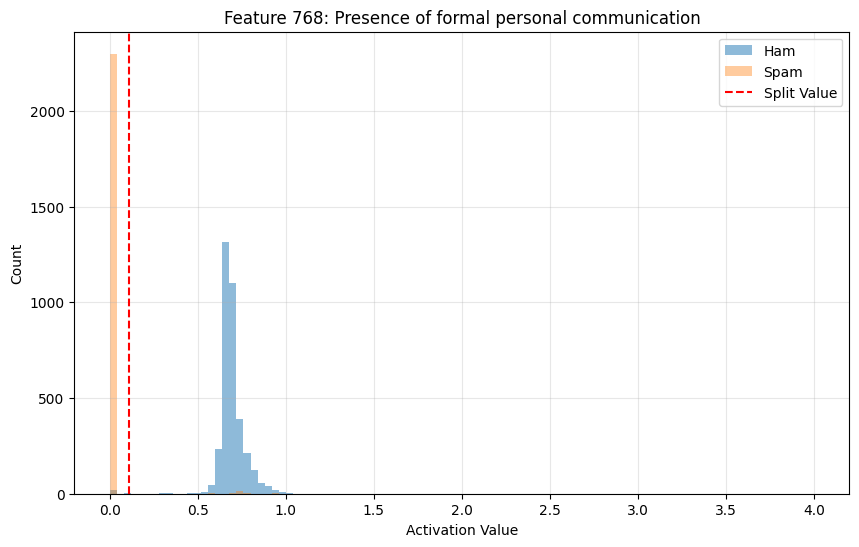

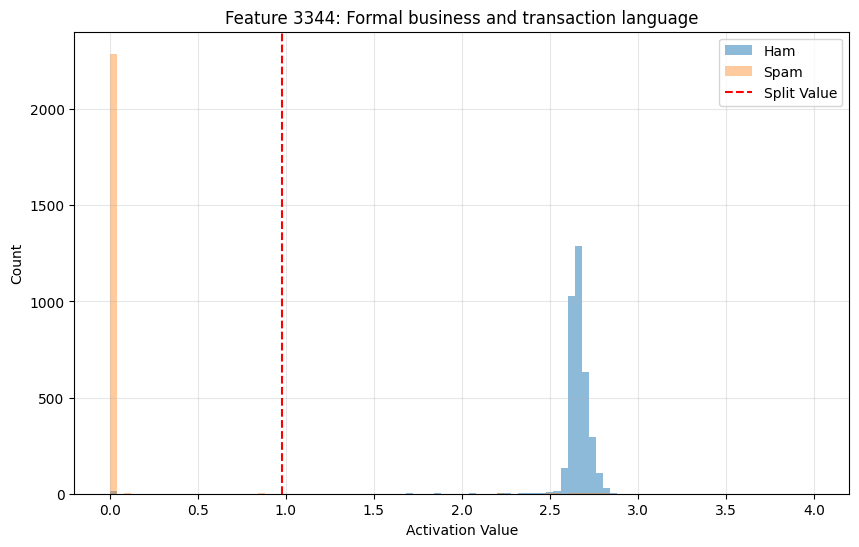

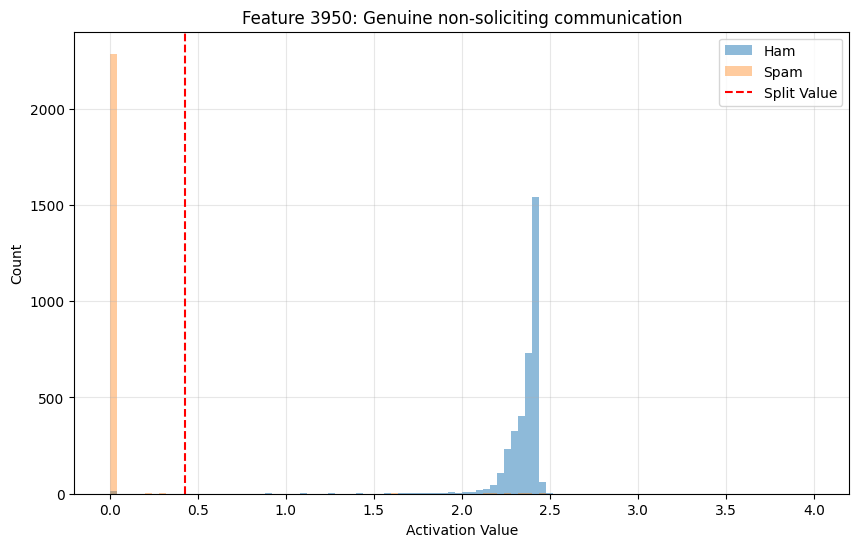

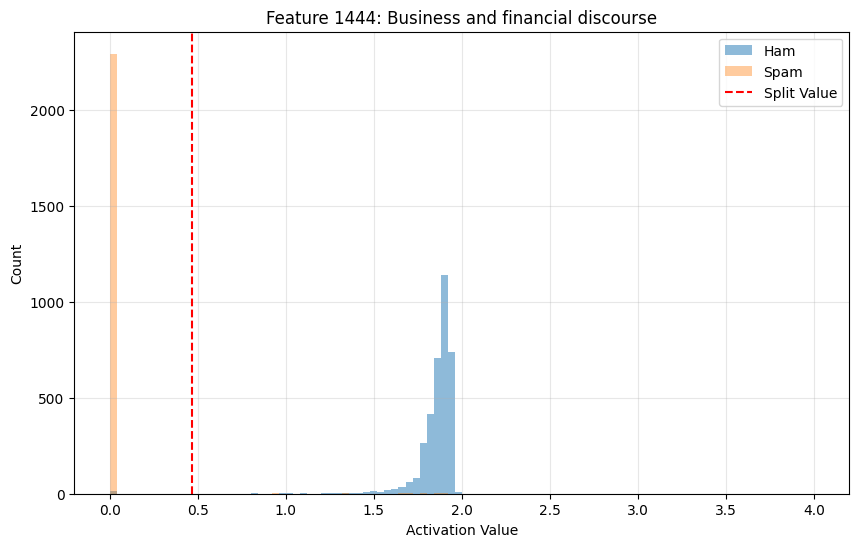

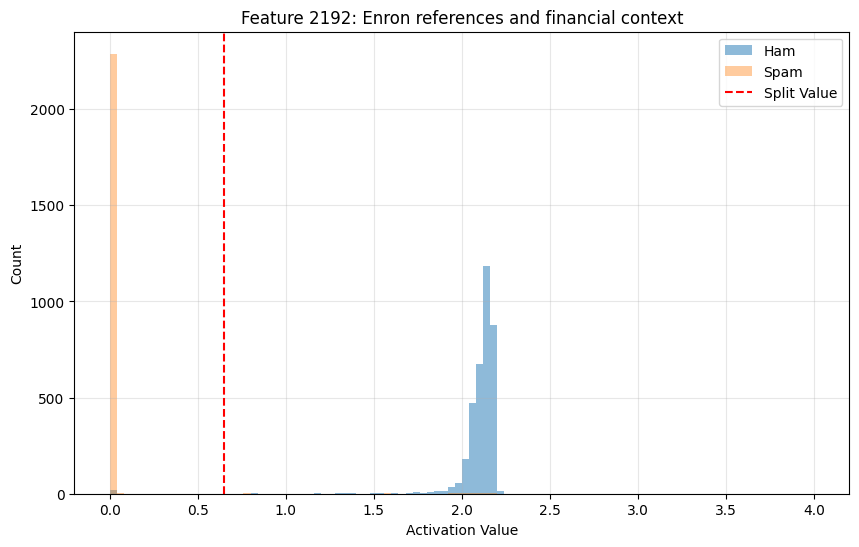

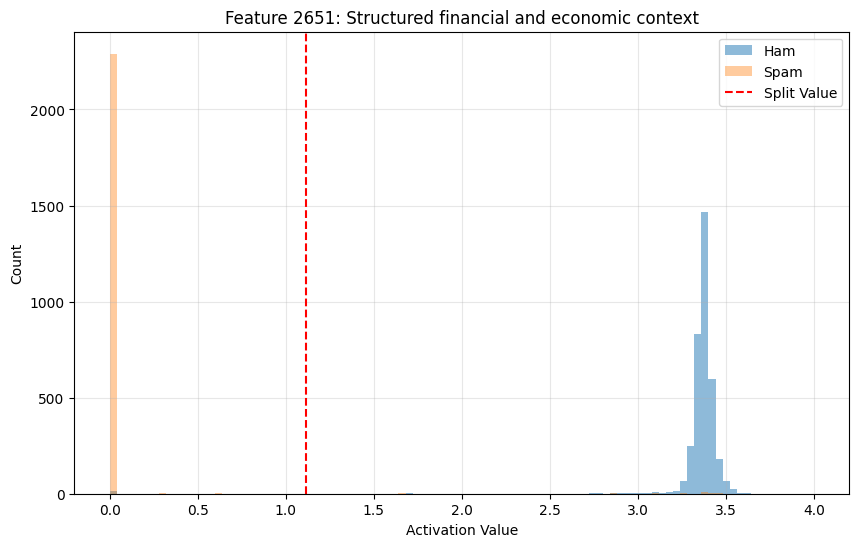

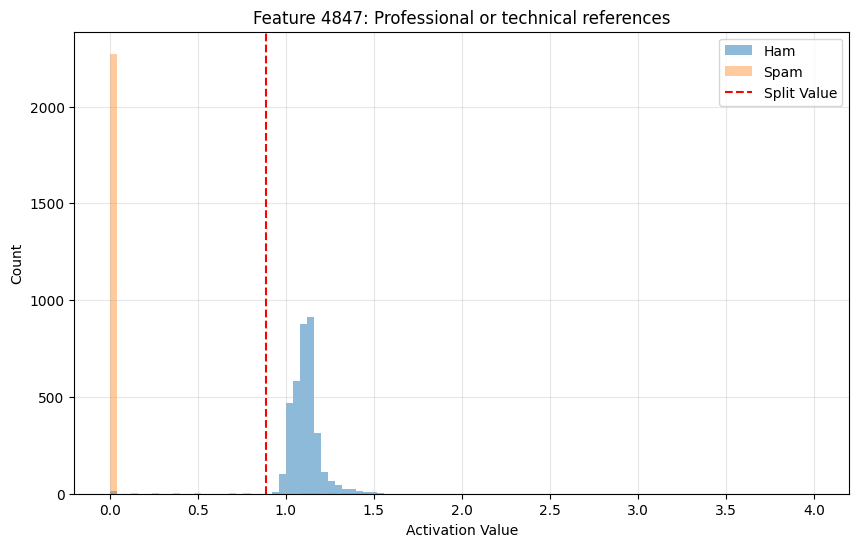

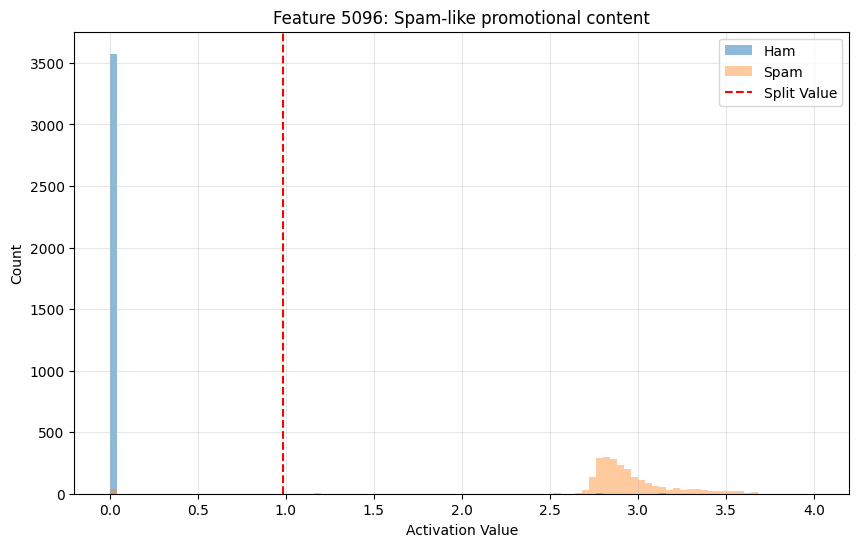

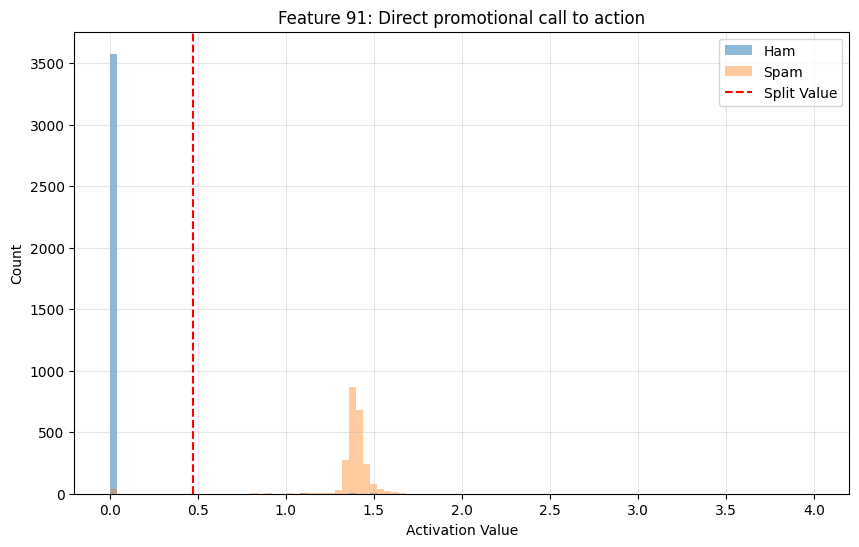

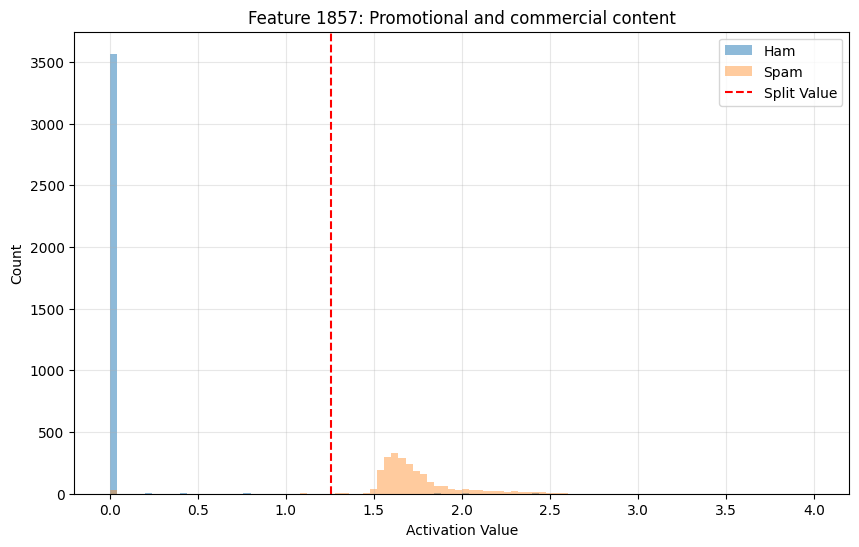

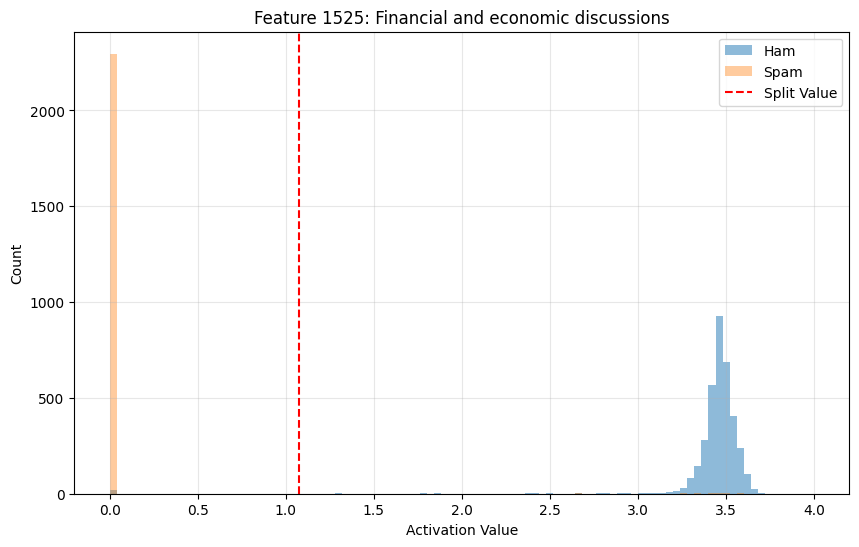

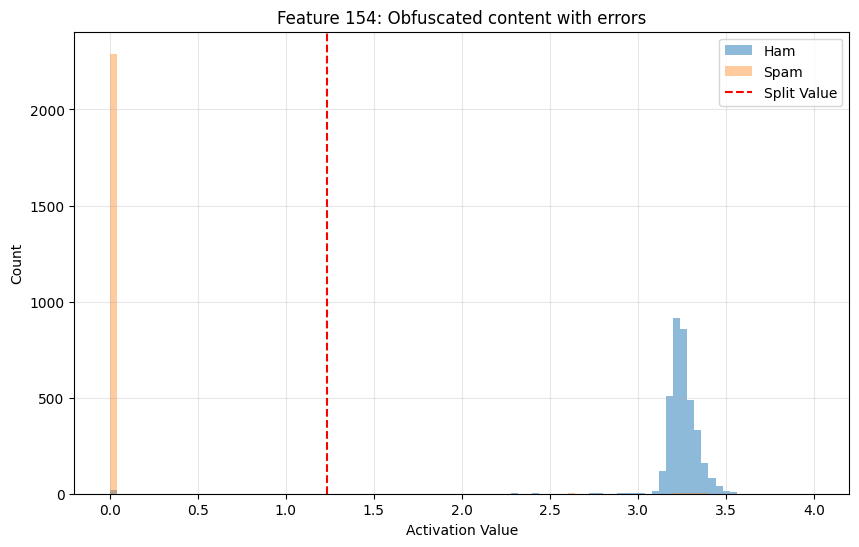

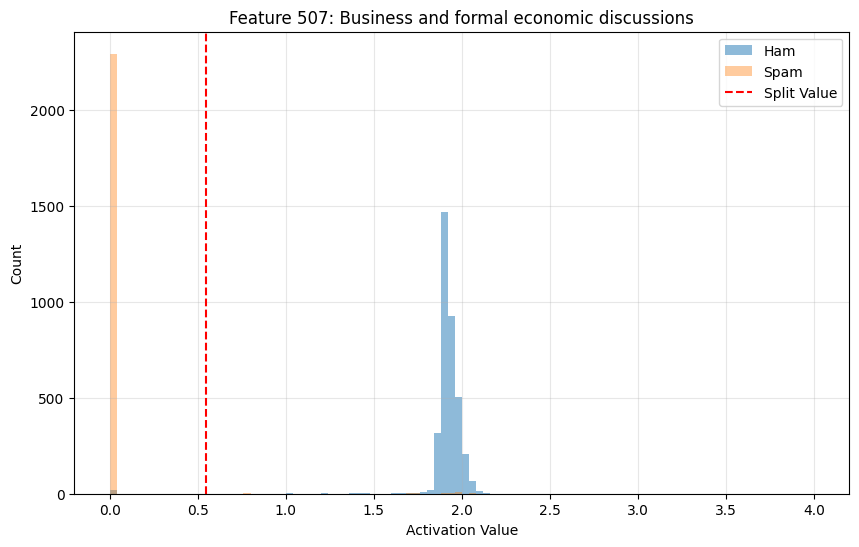

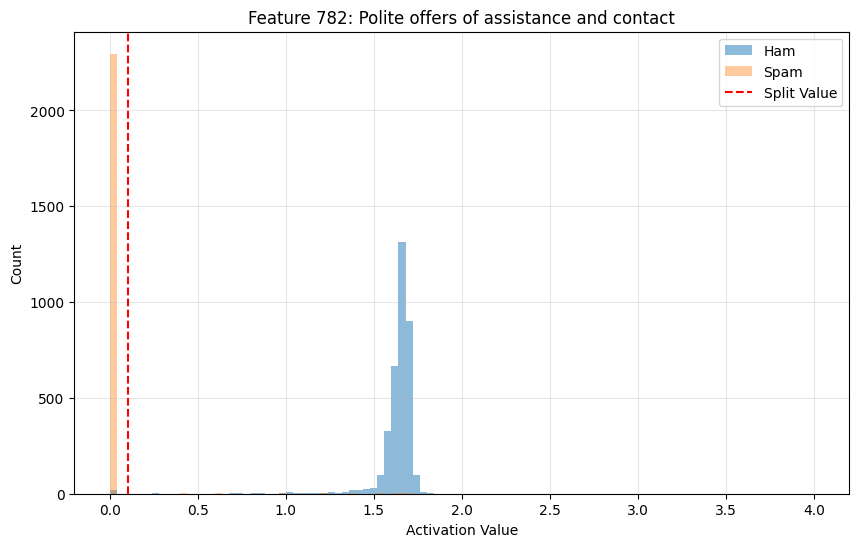

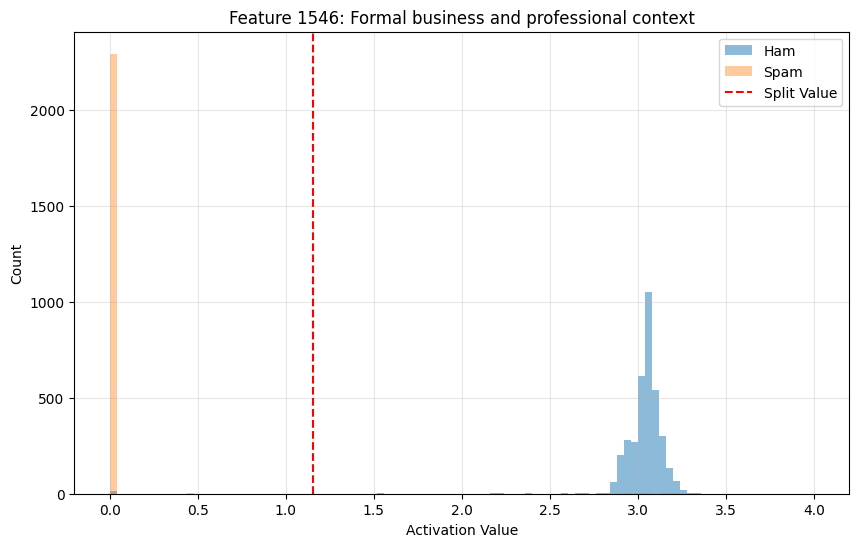

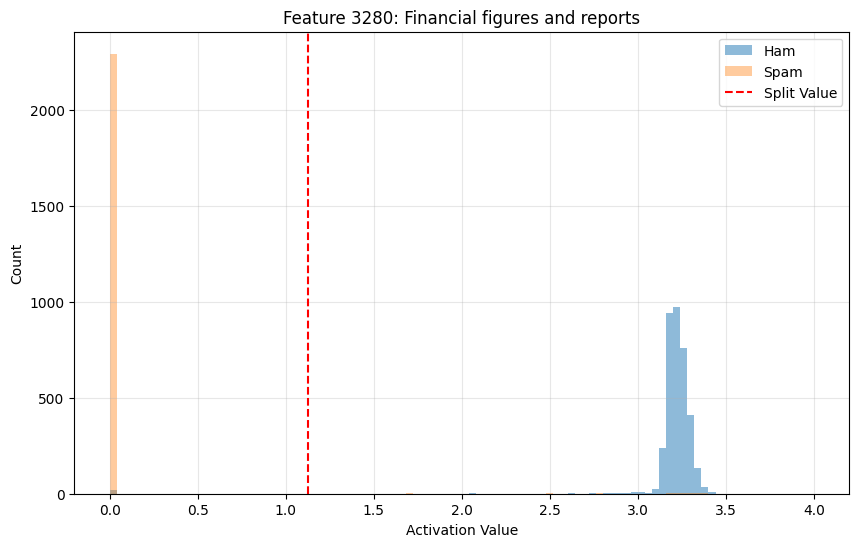

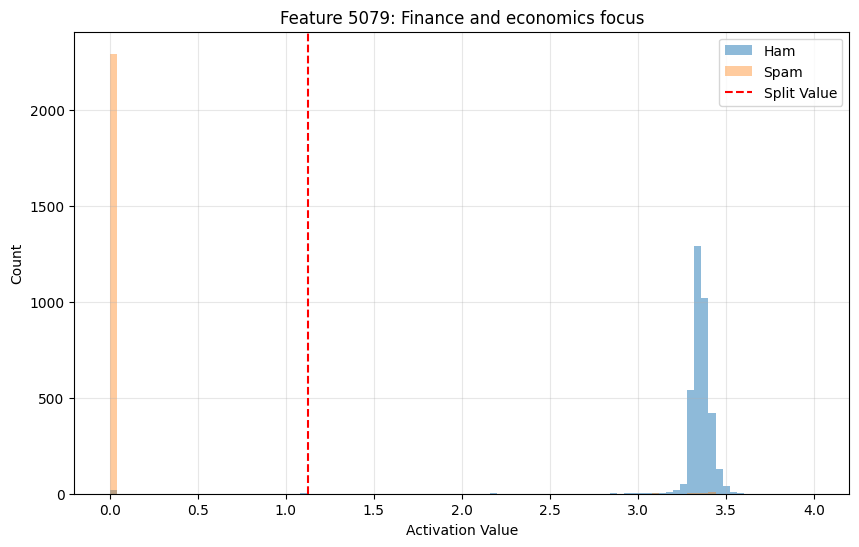

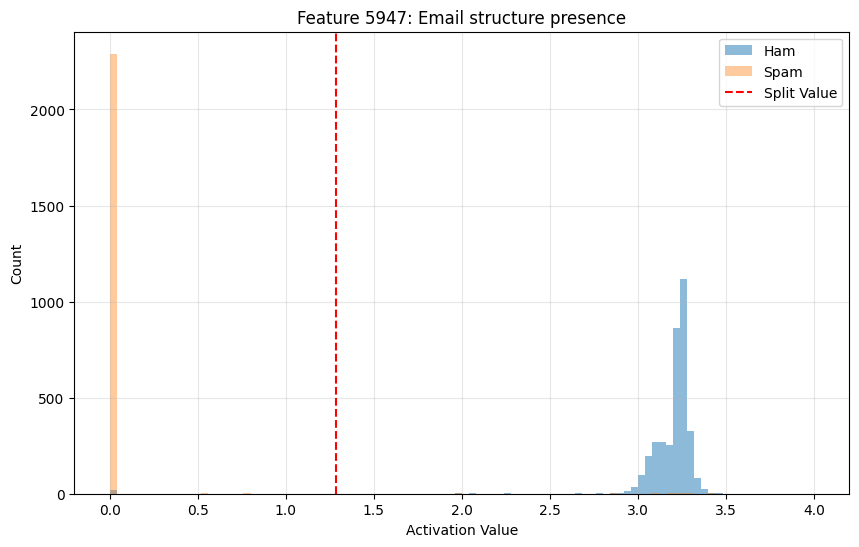

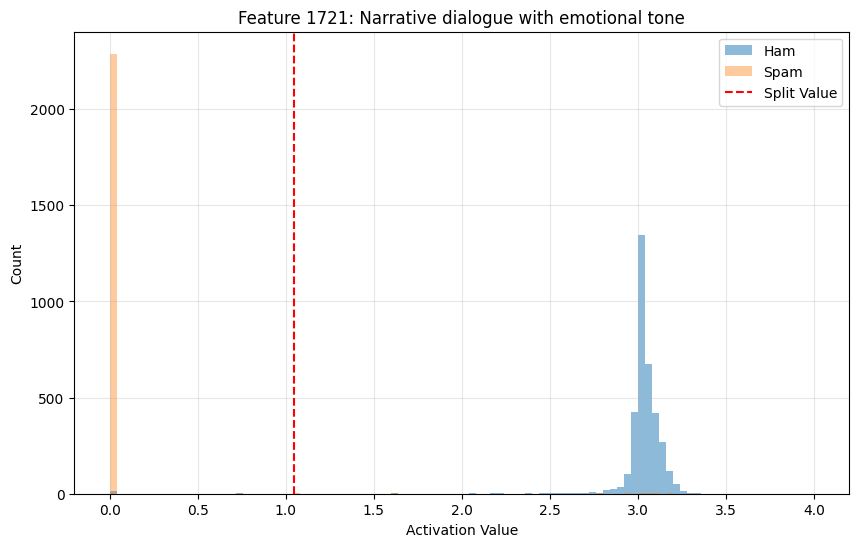

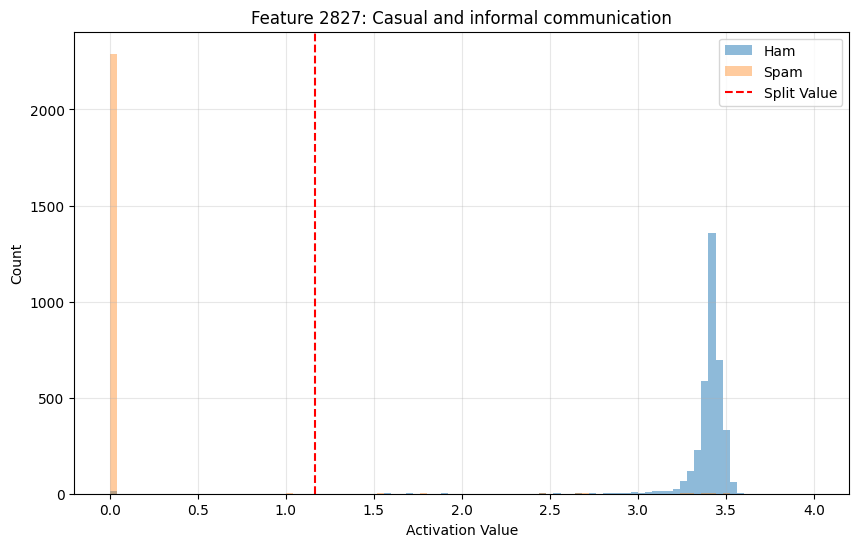

In [89]:
for result in main_results:
    idx = result['combo'][0][0]
    feature_idx = autointerp_feature_ids.index(idx)
    feature_name = autointerp_feature_labels[feature_idx]
    split_value = result['split_values']
    plot_feature_distribution(X_test, y_test, idx, feature_idx, feature_name, split_value)